# Exercise 4
Task:
- Implement DMDc as shown in Example 3.6
- Test script on data provided in handout 4
- Modify number of singular values and analyze effect on approximation quality





In [39]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp


from utils import utils

%matplotlib inline

In [40]:
def dynamic_mode_decomposition(x, x_prime,r):
    """Implementation of the dynamic mode decomposition algorithm.

    Args:
        x (numpy.ndarray): The data matrix.
        x_prime (numpy.ndarray): The data matrix shifted by one timestep.
        r (int): The rank of the reduced order model.

    Returns:
        numpy.ndarray: The DMD modes.
        numpy.ndarray: The eigenvalues.
    """
    # 1. compute SVD of x
    u, s, v_h = np.linalg.svd(x, full_matrices=False)
    
    # 2. truncate the SVD to rank r
    u_tilde = u[:, :r]
    s_tilde = np.diag(s[:r])
    v_h_tilde = v_h[:r, :]
    
    # 3. compute A_tilde -> reduced order operator
    u_h_tilde = u_tilde.conj().T
    v_sin_v = np.linalg.solve(s_tilde.conj().T,v_h_tilde).conj().T
    a_tilde = u_h_tilde @ x_prime @ v_sin_v

    # 4. compute eigenvalues and eigenvectors of A_tilde
    eigenvalues, eigenvectors = np.linalg.eig(a_tilde)

    # 5. compute DMD modes
    dmd_modes = x_prime @ v_sin_v @ eigenvectors # dmd_modes == phi

    return a_tilde, dmd_modes, eigenvalues
dmd = dynamic_mode_decomposition


In [41]:
def dynamic_mode_decomposition_control(x, x_prime, u, r):
    """ Implementation of dynamic mode decomposition with control.

    Args:
        x (numpy.ndarray): The data matrix.
        x_prime (numpy.ndarray): The data matrix shifted by one timestep.
        u (numpy.ndarray): The control matrix.
        r (int): The rank of the reduced order model.

    Returns:
        numpy.ndarray: The DMD modes.
        numpy.ndarray: The eigenvalues.
        numpy.ndarray: The reduced order input matrix.
    """
    omega = np.concatenate((x, u), axis=0)
    
    u_, s, v_h = np.linalg.svd(omega, full_matrices=False)

    u_tilde = u_[:, :r]
    s_tilde = np.diag(s[:r])
    v_h_tilde = v_h[:r, :]

    omega_pinv_tilde = np.linalg.solve(s_tilde.conj().T, v_h_tilde).conj().T
    ab_tilde = x_prime @ omega_pinv_tilde @ u_tilde

    a_tilde = ab_tilde[:, :x.shape[0]]
    b_tilde = ab_tilde[:, x.shape[0]:]

    eigenvalues, eigenvectors = np.linalg.eig(a_tilde)

    modes = x_prime @ omega_pinv_tilde @ u_tilde @ eigenvectors

    return modes, eigenvalues, b_tilde

    


dmdc = dynamic_mode_decomposition_control

In [42]:
import numpy as np
from scipy.integrate import solve_ivp

# Define the model parameters
p = {
    'd': 1.0,  # diffusion parameter
    'c': 2.0,  # convection parameter
    'fun': lambda x, DxDz, z, t: -0.2 * x + 5 * np.sin(x)  # reaction function
}

# Define the input
# t = np.arange(0, 10.01, 0.01)
# u = np.heaviside(t - 1, 1) - 2 * np.heaviside(t - 2, 1) - np.heaviside(t - 3, 1) + 4 * np.heaviside(t - 4, 1) - 2 * np.heaviside(t - 6, 1)

# Define the PDE solver
def solve_pde(p, ic, t_span, z_span):
    def pde_system(t, x):
        DxDz = np.gradient(x, z_span)
        return p['fun'](x, DxDz, z_span, t)
    
    sol = solve_ivp(pde_system, t_span, ic, t_eval=np.linspace(t_span[0], t_span[1], len(z_span)))
    return sol.y, z_span, sol.t

# Initial condition (example)
ic = np.zeros(100)  # Replace with the actual initial condition

# Time and space spans
t_span = (0, 10)
z_span = np.linspace(0, 1, 100)

# Call the solver
x, z, t = solve_pde(p, ic, t_span, z_span)


In [ ]:
def solve_vanderpol(t,l,c,a,b,x0):
    """
    Solves the Van der Pol oscillator ODE

    System equations:
        dx_1 = x[1] / p['L']
        dx_2 = (-x[0] - p['a'] * x[1] * (x[1]**2 - p['b'])) / p['C']

    Args:
        t (numpy.ndarray): time vector
        l (float): inductance
        c (float): capacity
        a (float): parameter a
        b (float): parameter b
        x0 (numpy.ndarray): initial state

    Function Outputs:
        t (numpy.ndarray): time vector
        x (numpy.ndarray): numerical solution
    """
    # Define the system ODE
    def vanderpol_ode(t,x,a,b,c,l):
        """
        Van der Pol oscillator ODE
        
        Args:
            t (float): time
            x (numpy.ndarray): state vector
            a (float): parameter a
            b (float): parameter b
            c (float): parameter c
            l (float): parameter l
        """
        dx1 = x[1] / l
        dx2 = (-x[0] - a * x[1] * (x[1]**2 - b)) / c
        return [dx1, dx2]

    # Solve the ODE
    sol = solve_ivp(vanderpol_ode, [t[0], t[-1]], x0, t_eval=t, args=(a,b,c,l))

    # Return the time vector and numerical solution
    return sol.t, sol.y


# Params for the Van der Pol oscillator
t = np.linspace(0, 20, 1000)
l = 1.0
c = 1.0
a = 1.0
b = 1.0
x0 = [2.0, 0.0]

t, x = solve_vanderpol(t,l,c,a,b,x0)

plt.figure()
plt.plot(t, x[0, :], label='x1')
plt.plot(t, x[1, :], label='x2')
plt.xlabel('Time')
plt.ylabel('States')
plt.title('Van der Pol Oscillator')
plt.legend()
plt.show()


TypeError: solve_vanderpol.<locals>.vanderpol_ode() takes 5 positional arguments but 6 were given

/tmp/ipykernel_20898/446670494.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  z[:, 0] = Ut[:, 0]


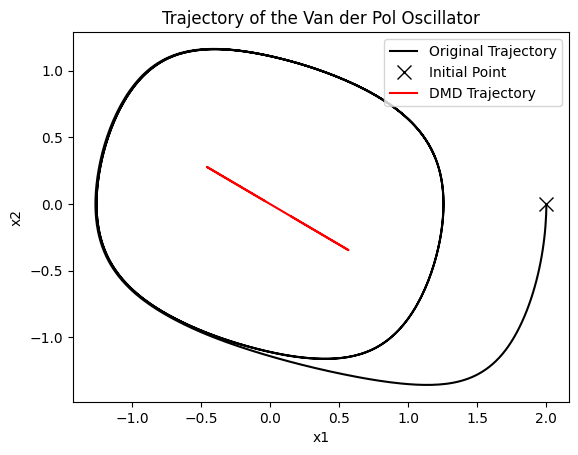

In [56]:
# Define Hankel matrix
hrow = 1
def hankel(hrow,x,t):
    """ Create Hankel matrix from the data matrix.

    Hankel matrix is created from the data matrix by shifting the data matrix by one timestep.

    Args:
        hrow (int): The number of rows in the Hankel matrix.
        x (numpy.ndarray): The data matrix.
        t (numpy.ndarray): The time vector.

    Returns:
        numpy.ndarray: The Hankel matrix
    """
    mt = round(0.5 * len(t))
    Xtd = x[:, :mt]
    Xtdp = x[:, 1:mt+1]

    for j in range(2, hrow+1):
        Xtd = np.vstack((Xtd, x[:, j-1:mt+j-1]))
        Xtdp = np.vstack((Xtdp, x[:, j:mt+j]))
    
    return Xtd, Xtdp

Xtd, Xtdp = hankel(hrow,x,t)

# Compute DMD
r = hrow * 2 
At, Ut, *_ = dmd(Xtd, Xtdp, r)

# Solve resulting DMD system
z = np.zeros((r, len(t)))
z[:, 0] = Ut[:, 0]

for i in range(1, len(t)):
    z[:, i] = At @ z[:, i-1]

xdmd = Ut @ z


# Plot trajectory
plt.figure()
plt.plot(x[0, :], x[1, :], 'k-')
plt.plot(x[0, 0], x[1, 0], 'kx', markersize=10)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Trajectory of the Van der Pol Oscillator')

# Plot DMD solution
plt.plot(xdmd[0, :], xdmd[1, :], 'r-')
plt.legend(['Original Trajectory', 'Initial Point', 'DMD Trajectory'])
plt.show()